In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_curve, auc
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os
import time 

# 3. Random forest 

## 3.1. Loading saved train/test data 

In [3]:
X_train_unigram = pickle.load(open("savedData/X_train_unigram","rb"))
X_test_unigram = pickle.load(open("savedData/X_test_unigram","rb"))
unigram_features = pickle.load(open("savedData/unigram_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_unigram.shape))
print('shape of X_test_bow is {}'.format(X_test_unigram.shape))


X_train_bigram = pickle.load(open("savedData/X_train_bigram","rb"))
X_test_bigram = pickle.load(open("savedData/X_test_bigram","rb"))
bigram_features = pickle.load(open("savedData/bigram_features","rb")).tolist()
print('shape of X_train_bigram is {}'.format(X_train_bigram.shape))
print('shape of X_test_bigram is {}'.format(X_test_bigram.shape))


X_train_tfidf = pickle.load(open("savedData/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("savedData/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("savedData/tfidf_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_tfidf.shape))
print('shape of X_test_bow is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("savedData/w2v_words","rb")).tolist()
X_train_avgw2v = pickle.load(open("savedData/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("savedData/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


y_train = np.load('savedData/y_train.npy',allow_pickle=True)
y_test = np.load('savedData/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (70000, 78273)
shape of X_test_bow is (30000, 78273)
shape of X_train_bigram is (70000, 1125166)
shape of X_test_bigram is (30000, 1125166)
shape of X_train_bow is (70000, 78006)
shape of X_test_bow is (30000, 78006)
shape of X_train_avgw2v is (70000, 50)
shape of X_test_avgw2v is (30000, 50)
shape of y_train is (70000,)
shape of y_test is (30000,)


## 3.2. Random forest on unigram features 

In [16]:
t= time.time()
clf = RandomForestClassifier(n_jobs=-1)
number_of_estimators = [5, 10, 50, 100, 120]
max_depth =[1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': number_of_estimators ,'max_depth':max_depth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_unigram,y_train)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 213.98333096504211 seconds.


{'max_depth': 30, 'n_estimators': 100}


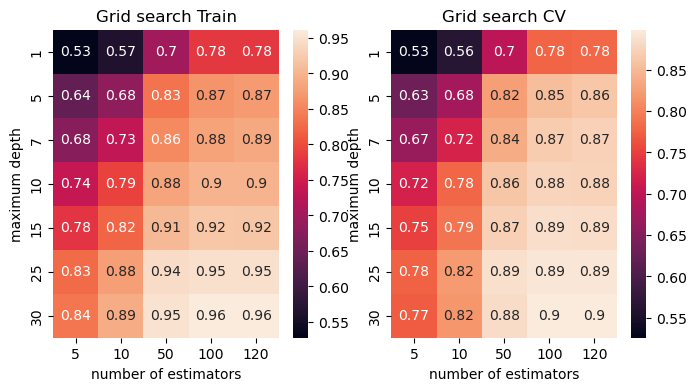

In [21]:
best_param_unigram = model.best_params_
print(best_param_unigram)

train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

fig, axes = plt.subplots(1,2,figsize= (8,4))
for i in range(2):
    title = train_auc if i == 0 else cv_auc
    sns.heatmap(title,xticklabels=number_of_estimators,yticklabels=max_depth,annot=True,ax=axes[i])
    axes[i].set_title(f"Grid search {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("number of estimators")
    axes[i].set_ylabel("maximum depth")



In [25]:
model_opt_unigram = RandomForestClassifier(**best_param_unigram)
model_opt_unigram = model_opt_unigram.fit(X_train_unigram,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, model_opt_unigram.predict_proba(X_train_unigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_opt_unigram.predict_proba(X_test_unigram)[:,1])


auc_train_unigram = auc(train_fpr, train_tpr)
auc_test_unigram  = auc(test_fpr, test_tpr)
print(F"Train AUC = {auc_train_unigram}\n")
print(F"Test AUC = {auc_test_unigram}\n")


Train AUC = 0.9564764680561674

Test AUC = 0.9035094718447649



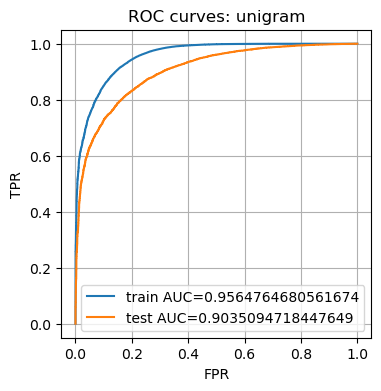

In [26]:
fig, ax = plt.subplots(figsize = (4,4))
ax.plot(train_fpr,train_tpr,label='train AUC='+str(auc_train_unigram))
ax.plot(test_fpr,test_tpr,label='test AUC='+str(auc_test_unigram))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid(True)
ax.legend()
ax.set_title('ROC curves: unigram')
plt.show()

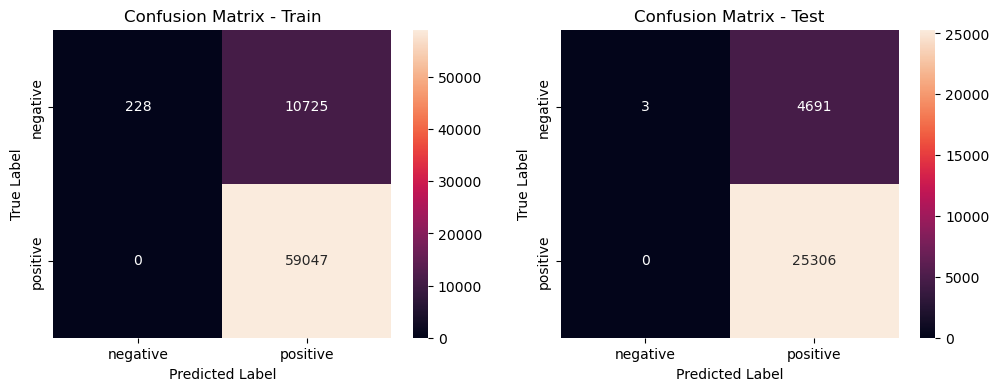

In [30]:
plot_confusion_matrixes(model_opt_unigram,X_train_unigram,y_train,X_test_unigram,y_test)

In [29]:
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
        df = df_train if i==0 else df_test
        sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
        axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
        axes[i].set_xlabel("Predicted Label")
        axes[i].set_ylabel("True Label")
    plt.show()

In [59]:
feature_importance_unigram = model_opt_unigram.feature_importances_
features = unigram_features
df_features = pd.DataFrame(feature_importance_unigram,columns=['coef'],index=features)
important_features_unigram = df_features.sort_values(by='coef',ascending=False).head(20)
important_features_unigram

,coef
disappoint,0.023921
great,0.015085
return,0.013541
wast,0.011159
horribl,0.010812
bad,0.009832
love,0.009036
aw,0.008472
refund,0.008338
money,0.008066


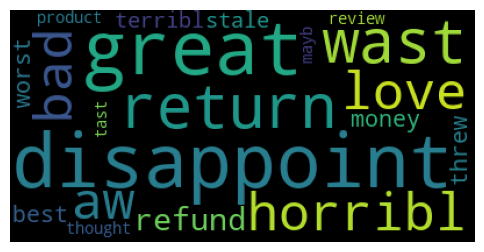

In [81]:
from wordcloud import WordCloud
words_unigram = ' '.join(list(important_features_unigram.index.values))
wordcloud = WordCloud().generate(words_unigram)
plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 3.3. Random forest on bigram features 

In [93]:
t= time.time()
clf = RandomForestClassifier(n_jobs=-1)
number_of_estimators = [5, 10, 50, 100, 120]
max_depth =[1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': number_of_estimators ,'max_depth':max_depth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_bigram,y_train)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 792.4320065975189 seconds.


{'max_depth': 30, 'n_estimators': 120}


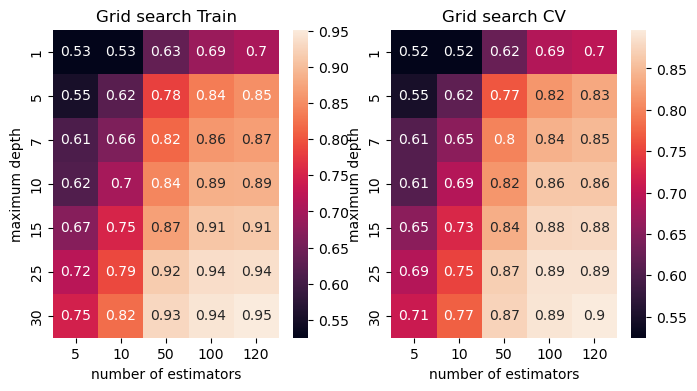

In [94]:
best_param_bigram = model.best_params_
print(best_param_bigram)

train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

fig, axes = plt.subplots(1,2,figsize= (8,4))
for i in range(2):
    title = train_auc if i == 0 else cv_auc
    sns.heatmap(title,xticklabels=number_of_estimators,yticklabels=max_depth,annot=True,ax=axes[i])
    axes[i].set_title(f"Grid search {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("number of estimators")
    axes[i].set_ylabel("maximum depth")



In [95]:
model_opt_bigram = RandomForestClassifier(**best_param_bigram)
model_opt_bigram = model_opt_bigram.fit(X_train_bigram,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, model_opt_bigram.predict_proba(X_train_bigram)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_opt_bigram.predict_proba(X_test_bigram)[:,1])


auc_train_bigram = auc(train_fpr, train_tpr)
auc_test_bigram  = auc(test_fpr, test_tpr)
print(F"Train AUC = {auc_train_bigram}\n")
print(F"Test AUC = {auc_test_bigram}\n")


Train AUC = 0.9420583036051245

Test AUC = 0.8925921876016005



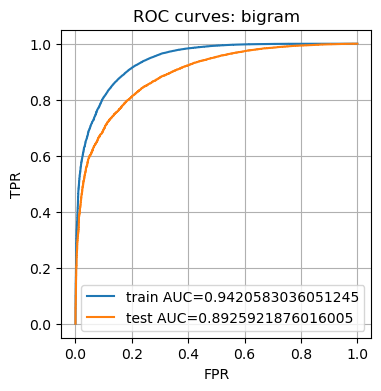

In [96]:
fig, ax = plt.subplots(figsize = (4,4))
ax.plot(train_fpr,train_tpr,label='train AUC='+str(auc_train_bigram))
ax.plot(test_fpr,test_tpr,label='test AUC='+str(auc_test_bigram))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid(True)
ax.legend()
ax.set_title('ROC curves: bigram')
plt.show()

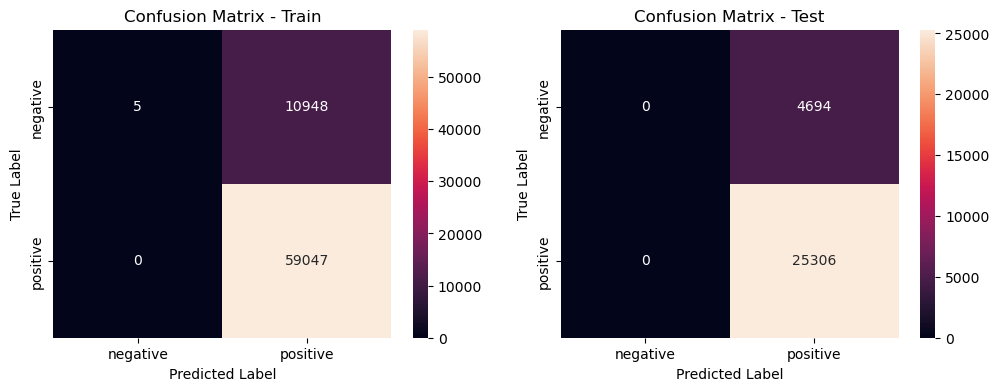

In [97]:
plot_confusion_matrixes(model_opt_bigram,X_train_bigram,y_train,X_test_bigram,y_test)

In [98]:
feature_importance_bigram = model_opt_bigram.feature_importances_
features = bigram_features
df_features = pd.DataFrame(feature_importance_bigram,columns=['coef'],index=features)
important_features_bigram = df_features.sort_values(by='coef',ascending=False).head(20)
important_features_bigram

,coef
money,0.014809
aw,0.011956
return,0.011063
worst,0.006599
never buy,0.005904
great,0.005439
would,0.005367
thought,0.005087
terribl,0.004826
throw away,0.004631


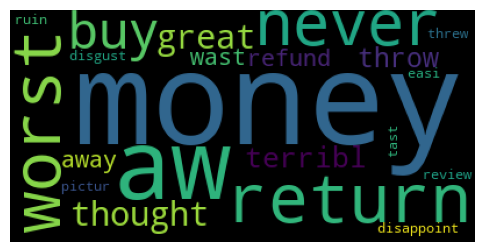

In [101]:
words_bigram = ' '.join(list(important_features_bigram.index.values))
wordcloud = WordCloud().generate(words_bigram)
plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 3.3. Random foreset on TF-IDF features 

In [70]:
t= time.time()
clf = RandomForestClassifier(n_jobs=-1)
number_of_estimators = [5, 10, 50, 100, 120]
max_depth =[1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': number_of_estimators ,'max_depth':max_depth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_tfidf,y_train)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 220.41647148132324 seconds.


{'max_depth': 30, 'n_estimators': 120}


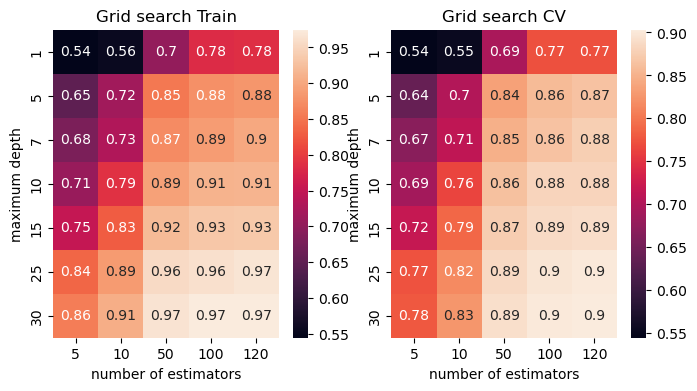

In [71]:
best_param_tfidf = model.best_params_
print(best_param_tfidf)

train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

fig, axes = plt.subplots(1,2,figsize= (8,4))
for i in range(2):
    title = train_auc if i == 0 else cv_auc
    sns.heatmap(title,xticklabels=number_of_estimators,yticklabels=max_depth,annot=True,ax=axes[i])
    axes[i].set_title(f"Grid search {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("number of estimators")
    axes[i].set_ylabel("maximum depth")


In [90]:
model_opt_tfidf = RandomForestClassifier(**best_param_tfidf)
model_opt_tfidf = model_opt_tfidf.fit(X_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, model_opt_tfidf.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_opt_tfidf.predict_proba(X_test_tfidf)[:,1])


auc_train_tfidf = auc(train_fpr, train_tpr)
auc_test_tfidf  = auc(test_fpr, test_tpr)
print(F"Train AUC = {auc_train_tfidf}\n")
print(F"Test AUC = {auc_test_tfidf}\n")

Train AUC = 0.9715611512106537

Test AUC = 0.904990412030795



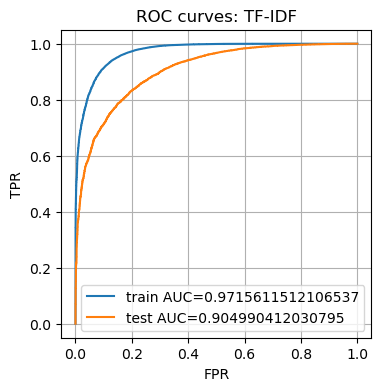

In [91]:
fig, ax = plt.subplots(figsize = (4,4))
ax.plot(train_fpr,train_tpr,label='train AUC='+str(auc_train_tfidf))
ax.plot(test_fpr,test_tpr,label='test AUC='+str(auc_test_tfidf))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid(True)
ax.legend()
ax.set_title('ROC curves: TF-IDF')
plt.show()

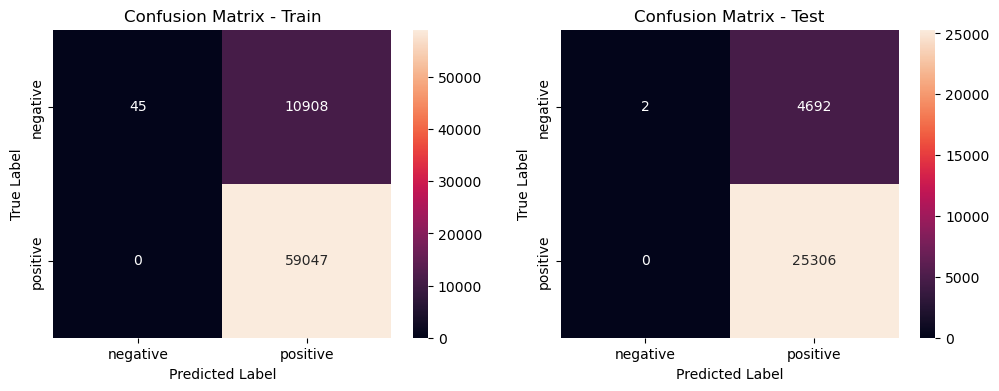

In [92]:
plot_confusion_matrixes(model_opt_tfidf,X_train_tfidf,y_train,X_test_tfidf,y_test)

In [73]:
feature_importance_tfidf = model_opt_tfidf.feature_importances_
features = tfidf_features
df_features = pd.DataFrame(feature_importance_tfidf,columns=['coef'],index=features)
important_features_tfidf= df_features.sort_values(by='coef',ascending=False).head(20)
important_features_tfidf

,coef
disappoint,0.030354
money,0.014942
return,0.014865
wast,0.013478
love,0.012185
great,0.012091
aw,0.011495
terribl,0.010558
refund,0.009319
would,0.008114


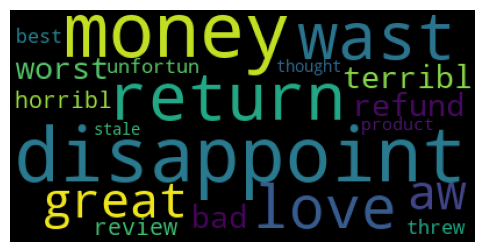

In [82]:
from wordcloud import WordCloud
words_tfidf = ' '.join(list(important_features_tfidf.index.values))
wordcloud = WordCloud().generate(words_tfidf)
plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 3.4. Random forest on average word2vec features

In [84]:
t= time.time()
clf = RandomForestClassifier(n_jobs=-1)
number_of_estimators = [5, 10, 50, 100, 120]
max_depth =[1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': number_of_estimators ,'max_depth':max_depth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='roc_auc',return_train_score=True)
model.fit(X_train_avgw2v,y_train)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 323.24497413635254 seconds.


{'max_depth': 15, 'n_estimators': 120}


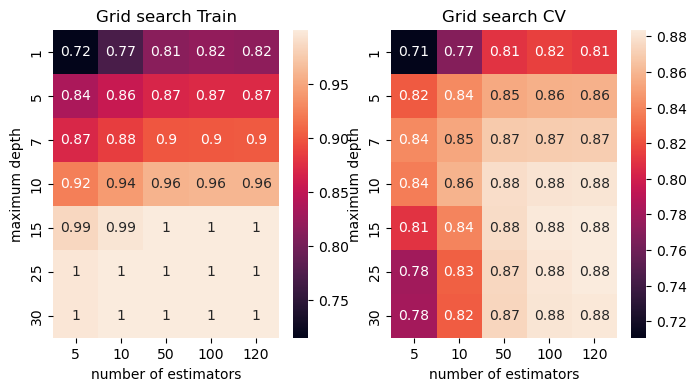

In [85]:
best_param_avgw2v = model.best_params_
print(best_param_avgw2v)

train_auc = model.cv_results_['mean_train_score'].reshape(7,5)
cv_auc = model.cv_results_['mean_test_score'].reshape(7,5)

fig, axes = plt.subplots(1,2,figsize= (8,4))
for i in range(2):
    title = train_auc if i == 0 else cv_auc
    sns.heatmap(title,xticklabels=number_of_estimators,yticklabels=max_depth,annot=True,ax=axes[i])
    axes[i].set_title(f"Grid search {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("number of estimators")
    axes[i].set_ylabel("maximum depth")


In [86]:
model_opt_avgw2v = RandomForestClassifier(**best_param_avgw2v)
model_opt_avgw2v = model_opt_tfidf.fit(X_train_avgw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, model_opt_avgw2v.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model_opt_avgw2v.predict_proba(X_test_avgw2v)[:,1])


auc_train_avgw2v = auc(train_fpr, train_tpr)
auc_test_avgw2v  = auc(test_fpr, test_tpr)
print(F"Train AUC = {auc_train_avgw2v}\n")
print(F"Test AUC = {auc_test_avgw2v}\n")

Train AUC = 0.9999998252780297

Test AUC = 0.8861930061265281



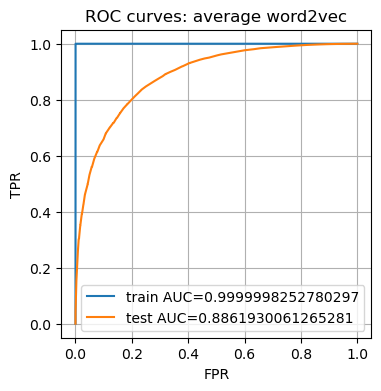

In [88]:
fig, ax = plt.subplots(figsize = (4,4))
ax.plot(train_fpr,train_tpr,label='train AUC='+str(auc_train_avgw2v))
ax.plot(test_fpr,test_tpr,label='test AUC='+str(auc_test_avgw2v))
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.grid(True)
ax.legend()
ax.set_title('ROC curves: average word2vec')
plt.show()

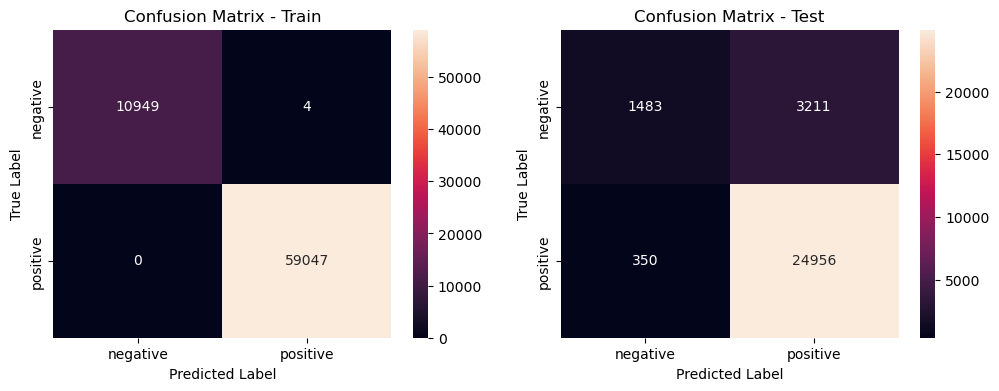

In [89]:
plot_confusion_matrixes(model_opt_avgw2v,X_train_avgw2v,y_train,X_test_avgw2v,y_test)

In [102]:
best_param_avgw2v

{'max_depth': 15, 'n_estimators': 120}

## 3.5. Summary: Model evaluation and feature importance

### Model evaluation

The hyperparameter tuning results and the train/test AUCs are given below for different word vectorization methods. In general, the model performances are not as good as the ones by logistic regressions. Most of the models are overfitting, especially the one with average word2vec features. Among different vectorization methods, the unigram and TF-IDF features have relatively higher accuracy. 

In [106]:
from tabulate import tabulate
 
# assign data
tb = [['unigram',best_param_unigram['n_estimators'],best_param_unigram['max_depth'],auc_train_unigram,auc_test_unigram],
     ['bigram',best_param_bigram['n_estimators'],best_param_bigram['max_depth'],auc_train_bigram,auc_test_bigram],
     ['TF-IDF',best_param_tfidf['n_estimators'],best_param_tfidf['max_depth'],auc_train_tfidf,auc_test_tfidf],
     ['avg w2v',best_param_avgw2v['n_estimators'],best_param_avgw2v['max_depth'],auc_train_avgw2v,auc_test_avgw2v]]
 
# create header
head =  ["Vector","Hyperparameter-no. of estimators ", "Hyperparameter-maximum depth", "Train AUC", "Test AUC"]
 
# display table
print(tabulate(tb, headers=head, tablefmt="github"))

| Vector   |   Hyperparameter-no. of estimators  |   Hyperparameter-maximum depth |   Train AUC |   Test AUC |
|----------|-------------------------------------|--------------------------------|-------------|------------|
| unigram  |                                 100 |                             30 |    0.956476 |   0.903509 |
| bigram   |                                 120 |                             30 |    0.942058 |   0.892592 |
| TF-IDF   |                                 120 |                             30 |    0.971561 |   0.90499  |
| avg w2v  |                                 120 |                             15 |    1        |   0.886193 |


### Feature importance

We are able to gain insights on which features are the most relavent. Specifically in our models, random forest models allow us to understand what words have the largest impact on the review sentiments. 
With unigram, bigram, and TF-IDF features, the top 3 important words are given in the table below.  

In [5]:
# assign data
tb = [['1. ','disappoint','money','disappoint'],
     ['2. ','great','aw','money'],
     ['3. ','return','return','return']]
# create header
head =  ["Order","Unigram ", "Bigram", "TF-IDF"]
 
# display table
print(tabulate(tb, headers=head, tablefmt="github"))

|   Order | Unigram    | Bigram   | TF-IDF     |
|---------|------------|----------|------------|
|       1 | disappoint | money    | disappoint |
|       2 | great      | aw       | money      |
|       3 | return     | return   | return     |
